In [32]:
import os
print(os.listdir("../input"))
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random
import spacy
import re



['twitter-entity-sentiment-analysis']


In [33]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
valid_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
# train['is_train'], valid['is_train'] = True, False
all_df = train.append(valid)
all_df.index = range(len(pd.RangeIndex(len(all_df.index))))
all_df

,Id,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [34]:
labeled_df = train[['Sentiment', 'Tweet']].copy()
labeled_df['label'] = labeled_df.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_df = labeled_df.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_df.drop(labeled_df[(labeled_df['label'] == 2 )|(labeled_df['label'] == 3)].index, inplace=True)
labeled_df.drop(labeled_df[(labeled_df['Tweet'].map(len) > 300 )|(labeled_df['Tweet'].map(len) < 10)].index, inplace=True)
labeled_df.label.value_counts()

0    18425
1    16483
Name: label, dtype: int64

In [35]:
labeled_valid = valid[['Sentiment', 'Tweet']].copy()
labeled_valid['label'] = labeled_valid.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_valid.drop(labeled_valid[(labeled_valid['label'] == 2 )|(labeled_valid['label'] == 3)].index, inplace=True)
labeled_valid = labeled_valid.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_valid.label.value_counts()

1    285
0    172
Name: label, dtype: int64

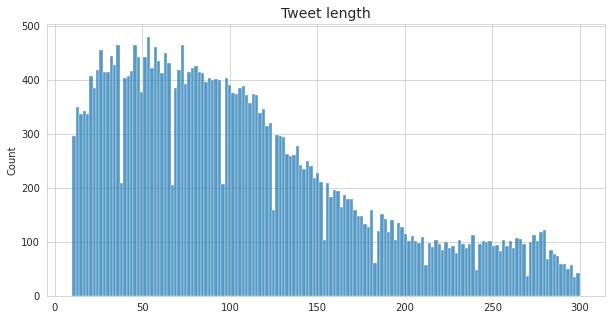

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in labeled_df['Tweet']], bins=150)
plt.title('Tweet length')
plt.show()

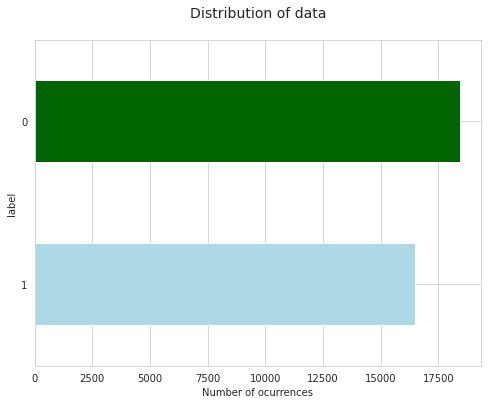

In [37]:
fig = plt.figure(figsize=(8,6))
colors = ['lightblue', 'darkgreen']#0-pos,1-neutr,2-neg
labeled_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [38]:
pos = labeled_df[labeled_df['label']==0].sample(16000, random_state=1).copy()
neu = labeled_df[labeled_df['label']==1].sample(16000, random_state=1).copy()
balanced_df = pos.append(neu).reset_index(drop=True)
balanced_df['label'] = balanced_df['label'].apply(lambda x: int(1) if x==2 else x)
balanced_df

,Tweet,label
0,I love the Champions League.,0
1,I wish Call of Duty Black Ops Cold War is comi...,0
2,The stupidest reason to troll a @ LeagueOfLege...,0
3,| So fun and I feel like causing mayhem . Yo...,0
4,of the setting. Frank Lawrence is back. Feels ...,0
...,...,...
31995,CSGO WIngman (Im Silver dont bully) twitch.tv ...,1
31996,PlayStation Plus Collection of PS4’s newest hi...,1
31997,<unk> win <unk>,1
31998,Great dissicion in covid time,1


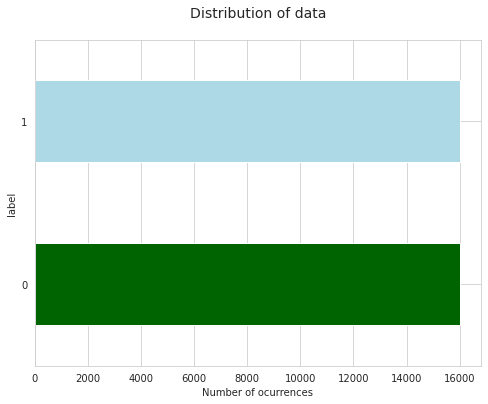

In [39]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen','lightblue']#0-pos,1-neu
balanced_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

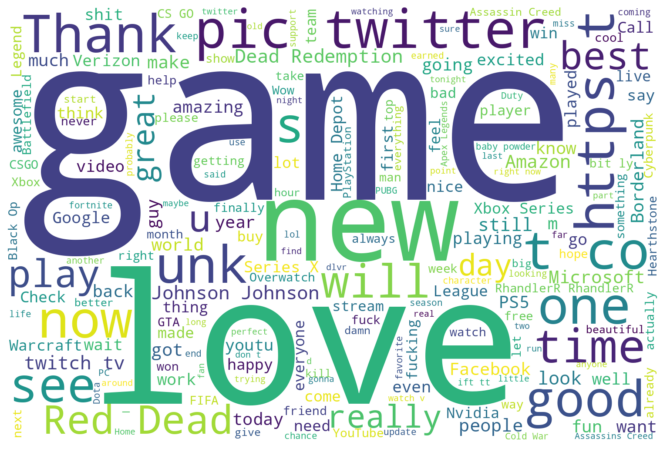

In [40]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(' '.join(balanced_df['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
for i,j in enumerate(['Positive','Neutral']):
    if i<3: print(j + ' mean sentence length: '+ str(pd.Series([len(s) for s in balanced_df[balanced_df['label']==i]['Tweet']]).mean()))
    else: print(j + ' mean sentence length: '+ str(pd.Series([len(s) for s in balanced_df['Tweet']]).mean()))

print()

for i,j in enumerate(['Positive','Neutral']):
    if i<3: print(j + ' median sentence length: '+ str(pd.Series([len(s) for s in balanced_df[balanced_df['label']==i]['Tweet']]).median()))
    else: print(j + ' median sentence length: '+ str(pd.Series([len(s) for s in balanced_df['Tweet']]).median()))


Positive mean sentence length: 99.221875
Neutral mean sentence length: 119.6408125

Positive median sentence length: 80.0
Neutral median sentence length: 108.0


## Sentiment Analysis using Transformers

More research on Sentiment Analysis with Transformers could be found in this [article](https://www.analyticsvidhya.com/blog/2022/02/sentiment-analysis-using-transformers/)

In [42]:
!pip install -U transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [44]:
labels = balanced_df['label'].tolist()
tweets = balanced_df['Tweet'].tolist()

[DistilBertTokenizerFast](https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/distilbert#transformers.DistilBertTokenizerFast) is identical to `BertTokenizerFast` and runs end-to-end tokenization: punctuation splitting and wordpiece.

In [45]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accef

In [46]:
inputs = tokenizer(tweets, padding='max_length', truncation = True)

Class for converting the data into tensors (since we are using PyTorch)

In [47]:
class twDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self,idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

`Input id’s`: This contains tensors of integers where each integer represents the word from the original sentence.

`Attention Mask`: It is simply an array of 1’s and 0’s indicating which tokens are padding and which aren’t.

`Labels`: target variables

In [48]:
tr_df = twDataset(inputs, labels)
tr_df.__getitem__(2000)

{'input_ids': tensor([  101, 16941, 14289,  8950, 19843,  2581,  2025,  2203,  2039,  2559,
          2066,  1037,  8827,  2487,  2208,  1999,  2026,  2291,  2021,  2009,
         10587,  2022,  4276,  2009,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

The Transformer model uses an attention-grabbing method that learns the contextual relationships between words (or small words) in a text. DistilBert has 40% fewer parameters than Bert-base based, 60% faster performance while saving more than 95% of BERT performance as measured in the GLUE language comprehension benchmark.

In [49]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 3)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-b

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [51]:
training_args = TrainingArguments(
output_dir = './results',
num_train_epochs=3,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
warmup_steps=500,
weight_decay=0.01,
logging_dir='./logs',
logging_steps=10,)
trainer=Trainer(
model=model,
args=training_args,
train_dataset=tr_df,
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
10,1.128300
20,1.128200
30,1.093300
40,1.036500
50,0.970600
60,0.881700
70,0.831400
80,0.754900
90,0.752500
100,0.708000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=6000, training_loss=0.1746259693162865, metrics={'train_runtime': 2772.2557, 'train_samples_per_second': 34.629, 'train_steps_per_second': 2.164, 'total_flos': 1.2717097058304e+16, 'train_loss': 0.1746259693162865, 'epoch': 3.0})

In [63]:
def to_check_result(test_encoding):
    input_ids=torch.tensor(test_encoding['input_ids']).to(device)
    attention_mask = torch.tensor(test_encoding['attention_mask']).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())
    return y

l2 list contains the output sentiment of the tweets in the test data.

In [64]:
l2 = []
for i in labeled_valid['Tweet']:
    test_encoding1 = tokenizer(i, truncation=True, padding=True)
    input_ids=torch.tensor(test_encoding1['input_ids']).to(device)
    attention_mask = torch.tensor(test_encoding1['attention_mask']).to(device)
    op = to_check_result(test_encoding1)
    l2.append(op)

In [54]:
# labeled_valid['label'] = labeled_valid['label'].apply(lambda x: int(1) if x==2 else x)

In [65]:
labeled_valid['label_pred']= l2
labeled_valid

,Tweet,label,label_pred
0,I mentioned on Facebook that I was struggling ...,0,1
1,BBC News - Amazon boss Jeff Bezos rejects clai...,1,1
4,Now the President is slapping Americans in the...,1,1
13,CSGO WIngman (Im Silver dont bully) twitch.tv/...,1,1
21,Anyone that plays a bad luck albatross deck in...,1,1
...,...,...,...
988,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...,1,1
991,Late night stream with the boys! Come watch so...,1,1
995,⭐️ Toronto is the arts and culture capital of ...,0,0
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,0,0


## Evaluate

* Accuracy 

Documentation of [sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(labeled_valid['label'].tolist(), l2)

0.7789934354485777

In [67]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(labeled_valid['label'].tolist(), l2, target_names=['Positive','Neutral']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.92      0.45      0.61       172
     Neutral       0.75      0.98      0.85       285

    accuracy                           0.78       457
   macro avg       0.83      0.71      0.73       457
weighted avg       0.81      0.78      0.76       457



## Confusion Matrix

In [58]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), 119.69 KiB | 492.00 KiB/s, done.


In [59]:
url = f"https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py"
!wget --no-cache --backups=1 {url}
import subprocess
result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2022-05-19 14:25:12--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4088 (4.0K) [text/plain]
Failed to rename cf_matrix.py to cf_matrix.py.1: (2) No such file or directory
Saving to: ‘cf_matrix.py’

cf_matrix.py        100%[===================>]   3.99K  --.-KB/s    in 0s      

2022-05-19 14:25:12 (31.1 MB/s) - ‘cf_matrix.py’ saved [4088/4088]

hugging

In [60]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [61]:
conf_mat = confusion_matrix(labeled_valid['label'].tolist(), l2)
conf_mat

array([[ 78,  94],
       [  7, 278]])

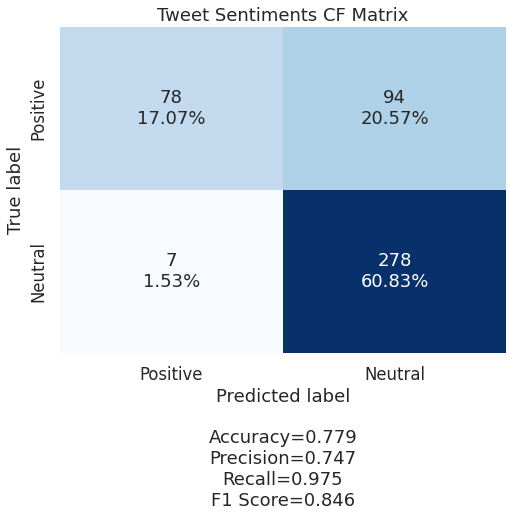

In [68]:
categories = ['Positive','Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')